# 分析 COVID-19 論文

在這項挑戰中，我們將繼續探討 COVID 疫情的主題，並專注於處理有關該主題的科學論文。有一個 [CORD-19 資料集](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)，其中包含超過 7000 篇（撰寫本文時的數量）關於 COVID 的論文，並附有元數據和摘要（其中約有一半還提供了全文）。

使用 [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) 認知服務分析此資料集的完整範例已在[這篇部落格文章](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/)中描述。我們將討論此分析的簡化版本。


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 獲取數據

首先，我們需要獲取我們將要處理的 CORD 論文的元數據。

**注意**：我們並未在此存儲庫中提供數據集的副本。您需要先從 [Kaggle 上的這個數據集](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) 下載 [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) 文件。可能需要註冊 Kaggle。您也可以從[這裡](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html)下載數據集，無需註冊，但這將包含所有全文以及元數據文件。

我們將嘗試直接從線上來源獲取數據，但如果失敗，您需要按照上述說明下載數據。此外，如果您計劃進一步實驗，下載數據是有意義的，這樣可以節省等待時間。

> **注意** 數據集相當大，大約 1 GB，以下這行代碼可能需要很長時間才能完成！（約 5 分鐘）


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

我們現在將把出版日期欄位轉換為 `datetime`，並繪製直方圖來查看出版日期的範圍。


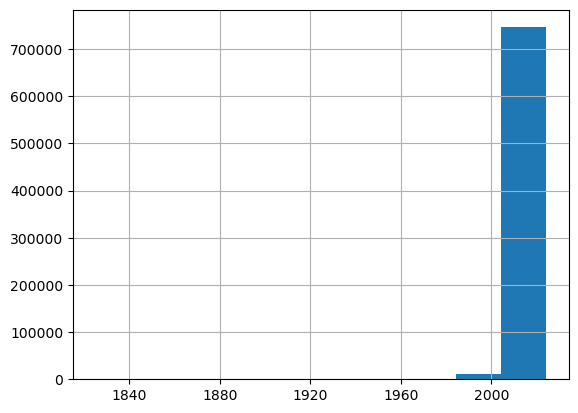

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## 結構化數據提取

讓我們看看可以從摘要中輕鬆提取哪些信息。我們可能感興趣的一件事是了解有哪些治療策略存在，以及它們如何隨著時間演變。首先，我們可以手動整理出用於治療 COVID 的可能藥物清單，以及診斷清單。接著，我們逐一檢視它們，並在論文摘要中搜尋相應的術語。


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


我們已經在資料框中新增了多個欄位，這些欄位記錄了某種藥物或診斷在摘要中出現的次數。

> **注意** 我們在尋找子字串時，會在單字的開頭加上一個空格。如果不這樣做，可能會得到錯誤的結果，因為*chloroquine*也會被包含在*hydroxychloroquine*這個子字串中。此外，我們強制將摘要欄轉換為`str`類型，以避免出現錯誤——試著移除`str`看看會發生什麼。

為了讓數據處理更方便，我們可以提取只包含藥物計數的子框架，並計算累積出現次數。這樣可以找出最受歡迎的藥物：


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

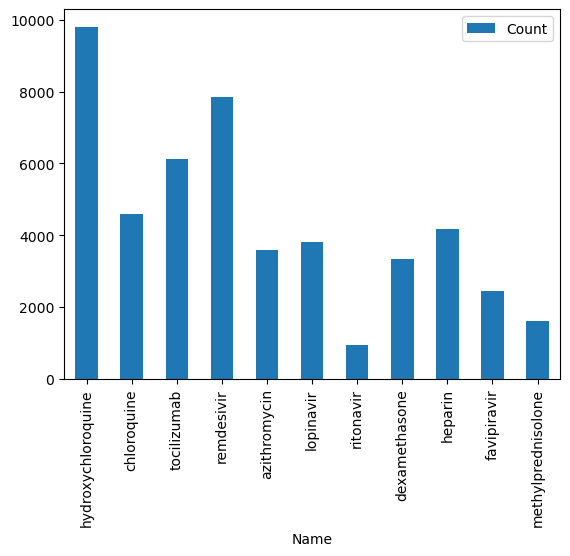

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## 尋找治療策略的趨勢

在上述範例中，我們已經對所有數值進行了 `sum` 總和，但我們也可以按月進行相同的操作：


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

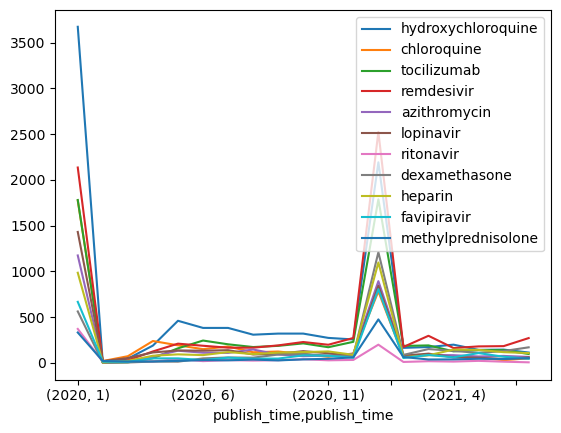

In [152]:
dfmt.plot()
plt.show()

一個有趣的觀察是，我們在兩個時間點出現了巨大的峰值：2020年1月和2021年1月。這是因為某些論文的出版日期並未明確指定，因此被標註為該年份的1月。

為了讓數據更有意義，我們來可視化幾種藥物。我們還會「刪除」1月的數據，並用某些中間值填充，以便生成更美觀的圖表：


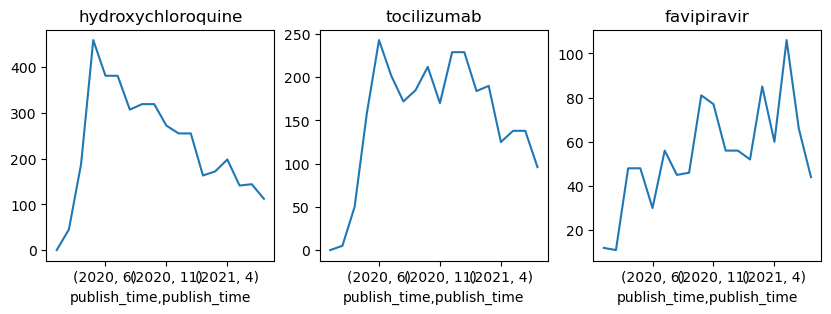

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

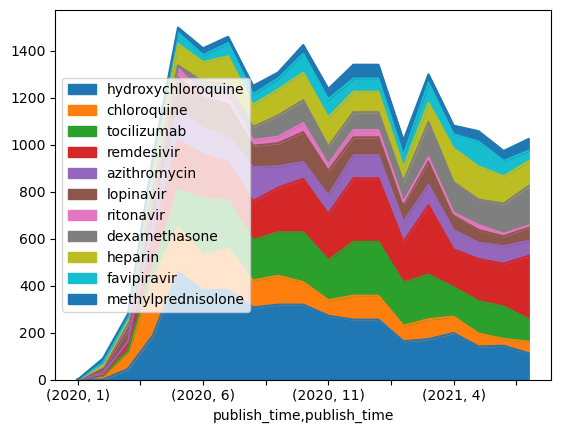

In [154]:
dfmt.plot.area()
plt.show()

甚至進一步，我們可以以百分比計算相對受歡迎程度：


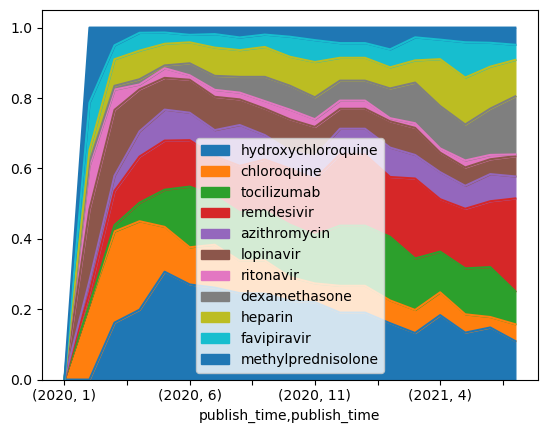

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## 計算藥物與診斷的對應關係

我們可以探索的一個最有趣的關係是不同的診斷如何使用不同的藥物進行治療。為了將其可視化，我們需要計算**共現頻率圖**，這將顯示兩個術語在同一篇論文中被提及的次數。

這樣的圖本質上是一個二維矩陣，最適合用**numpy array**來表示。我們將通過遍歷所有摘要來計算這個圖，並標記出在摘要中出現的實體：


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

其中一種視覺化此矩陣的方法是繪製一個**熱圖**：


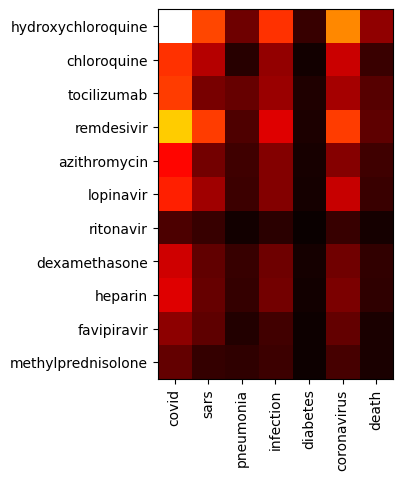

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

然而，使用所謂的 **Sankey** 圖表可以實現更好的可視化效果！`matplotlib` 並不內建支援這種類型的圖表，因此我們需要使用 [Plotly](https://plotly.com/python/)，如同 [這篇教學](https://plotly.com/python/sankey-diagram/) 所描述的。

要製作 Plotly 的 Sankey 圖表，我們需要建立以下幾個列表：
* 列表 `all_nodes`，包含圖中所有的節點，這些節點會包括藥物和診斷
* 來源和目標索引的列表——這些列表將顯示哪些節點位於圖表的左側，哪些位於右側
* 所有連結的列表，每個連結包含：
   - 在 `all_nodes` 陣列中的來源索引
   - 目標索引
   - 表示連結強度的值。這正是我們共現矩陣中的值。
   - （可選）連結的顏色。我們將提供一個選項來突出顯示某些術語以便更清晰

繪製 Sankey 圖表的通用程式碼被結構化為一個獨立的 `sankey` 函數，該函數接受兩個列表（來源和目標類別）以及共現矩陣。它還允許我們指定閾值，並省略所有低於該閾值的連結——這樣可以使圖表稍微簡化一些。


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## 結論

您已經看到，我們可以使用相當簡單的方法，從非結構化的數據來源（例如文本）中提取信息。在這個例子中，我們使用了現有的藥物清單，但如果使用自然語言處理（NLP）技術來進行文本中的實體提取，將會更具威力。在[這篇部落格文章](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/)中，我們描述了如何使用雲端服務進行實體提取。另一個選擇是使用 Python 的 NLP 函式庫，例如 [NLTK](https://www.nltk.org/)——使用 NLTK 從文本中提取信息的方法已在[這裡](https://www.nltk.org/book/ch07.html)進行了描述。


## 挑戰

繼續沿著以下方向研究 COVID 論文數據：

1. 建立不同藥物的共現矩陣，查看哪些藥物經常一起出現（即在同一篇摘要中提到）。您可以修改用於建立藥物和診斷共現矩陣的程式碼。
1. 使用熱圖來視覺化這個矩陣。
1. 作為進階目標，您可以嘗試使用 [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) 來視覺化藥物的共現情況。[這個庫](https://pypi.org/project/chord/) 可能會幫助您繪製 chord diagram。
1. 作為另一個進階目標，嘗試使用正則表達式提取不同藥物的劑量（例如 **400mg** 在 *每天服用 400mg 的氯喹* 中），並建立一個數據框，顯示不同藥物的不同劑量。**注意**：考慮與藥物名稱在文本中距離較近的數值。



---

**免責聲明**：  
本文件已使用 AI 翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。我們致力於提供準確的翻譯，但請注意，自動翻譯可能包含錯誤或不準確之處。應以原始語言的文件作為權威來源。對於關鍵資訊，建議尋求專業人工翻譯。我們對因使用此翻譯而引起的任何誤解或錯誤解讀概不負責。
